<a href="https://colab.research.google.com/github/jaotheboss/ESG-Disclosure-Analysis/blob/main/Main_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Analysis for DSA4264

**Task**:
Explore the relationship between a firm's environmental disclosure and financial performance. 


**Tasks**:
1. Extract out the text data of the firms that have available financial metrics
2. Filter out the environmental disclosures (sentence that contains the keywords or n-grams) from the text data
3. Concatenate all the sentences from each document and have each document form the observations of a corpus
4. Perform LDA or STM on the corpus
5. Analyse the results:
    
    - Between rating 1 and 5
    - Across the years
    - Both

## Setting up the modules and functions

In [63]:
# setting up the work directory
import os 
os.chdir('/content/drive/My Drive/School/NUS/Year 4 Sem 1/DSA4264/(TSX) Toronto')

!pip install pyLDAvis
!pip install pdfplumber

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.sklearn
import pdfplumber
import multiprocessing as mp

In [64]:
# defining functions
def _PREPROCESS(text, min_char_len = 3, max_char_len = 15):
    """
    Function:     Preprocesses and cleans text
                    
    Input:        Text array
    
    Returns:      A column of processed text
    """
    contractions = {
            "ain't": "am not / are not",
            "aren't": "are not / am not",
            "can't": "cannot",
            "can't've": "cannot have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he had / he would",
            "he'd've": "he would have",
            "he'll": "he shall / he will",
            "he'll've": "he shall have / he will have",
            "he's": "he has / he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how has / how is",
            "i'd": "I had / I would",
            "i'd've": "I would have",
            "i'll": "I shall / I will",
            "i'll've": "I shall have / I will have",
            "i'm": "I am",
            "i've": "I have",
            "isn't": "is not",
            "it'd": "it had / it would",
            "it'd've": "it would have",
            "it'll": "it shall / it will",
            "it'll've": "it shall have / it will have",
            "it's": "it has / it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she had / she would",
            "she'd've": "she would have",
            "she'll": "she shall / she will",
            "she'll've": "she shall have / she will have",
            "she's": "she has / she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as / so is",
            "that'd": "that would / that had",
            "that'd've": "that would have",
            "that's": "that has / that is",
            "there'd": "there had / there would",
            "there'd've": "there would have",
            "there's": "there has / there is",
            "they'd": "they had / they would",
            "they'd've": "they would have",
            "they'll": "they shall / they will",
            "they'll've": "they shall have / they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we had / we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what shall / what will",
            "what'll've": "what shall have / what will have",
            "what're": "what are",
            "what's": "what has / what is",
            "what've": "what have",
            "when's": "when has / when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where has / where is",
            "where've": "where have",
            "who'll": "who shall / who will",
            "who'll've": "who shall have / who will have",
            "who's": "who has / who is",
            "who've": "who have",
            "why's": "why has / why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you had / you would",
            "you'd've": "you would have",
            "you'll": "you shall / you will",
            "you'll've": "you shall have / you will have",
            "you're": "you are",
            "you've": "you have"}

    def contract(text):
        for word in text.split():
            if word.lower() in contractions:
                text = text.replace(word, contractions[word.lower()])
        return text
    
    def preprocess(text):
        # throw away numbers
        text = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z]+", ' ', str(text).lower()).strip() 
        doc = nlp(text)
        text = [token.lemma_ for token in doc if token.is_stop == False and len(token) >= min_char_len and len(token) <= max_char_len]
        new_text = ' '.join(text)
        return new_text
       
    text = text.apply(contract).apply(preprocess)
    return text

def extract_pdf_text(file_name, min_sent_len = 10):
    doc = []
    try:
        with pdfplumber.open(file_name) as pdf:
            pages = pdf.pages
            for i in pages:
                page = i.extract_text()
                if page:
                    doc.extend([sentence.string for sentence in nlp(page).sents if len(sentence.text.split()) >= min_sent_len])
    except:
        doc.extend(['Unrecognized PDF!!!'])
    doc = _PREPROCESS(pd.Series(doc))
    return doc

def get_top_k(df, vectorizer, k = 10):
       """get top k occuring words"""
       vectorizer.fit(df)
       counts = pd.DataFrame(vectorizer.transform(df).toarray())
       counts.columns = vectorizer.get_feature_names()
       counts = counts.apply(sum).sort_values(ascending = False)[:k]
       sns.barplot(x = counts.values, y = counts.index)

def display_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_words.append(top_words)
        print(", ".join(top_words))
        print()
    return topic_words

def summary_layout(*lsts):
    n_topics = len(lsts[0])
    for i in range(n_topics):
        str2print = 'topic ' + str(i) + '\n'
        for group in lsts:
            str2print += ', '.join(group[i])
            str2print += '\n'
        print(str2print)
        print()

## Preprocessing

In [65]:
# getting the file names
metadata = pd.read_csv('clustered_files_cleaned.csv')
def quantiles(arr):
    result = []
    quads = [np.quantile(arr, 0.25*i) for i in range(1, 4)]
    for i in arr:
        if i <= quads[0]:
            result.append(1)
        elif i <= quads[1]:
            result.append(2)
        elif i <= quads[2]:
            result.append(3)
        else:
            result.append(4)
    return result
metadata['rating_quarters'] = quantiles(metadata.earnings)

We will only be looking at the top and bottom 25% of the ratings. This is ensure that there is a discernible distinction in performance metric. By doing so, we hope to more clearly distinguish the aspects of an environmental disclosure that correlates with the financial metric

In [66]:
# filtering out by quarters
filtered_metadata = metadata[['finalfilename', 'fileyear', 'rating_quarters']]
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 2, :]  
filtered_metadata = filtered_metadata.loc[metadata.rating_quarters != 3, :]
filtered_metadata.reset_index(drop = True, inplace = True)
filtered_metadata

,finalfilename,fileyear,rating_quarters
0,TSX_7376__Absolute Software Corp___Active____(...,2018,4
1,TSX_7319__AcuityAds Holdings Inc___Active____(...,2018,1
2,TSX_1041__Alacer Gold Corp___Active____(2018-1...,2018,4
3,TSX_1041__Alexco Resource Corp___Active____(20...,2018,1
4,TSX_4449__Algoma Central Corp___Active____(201...,2018,1
...,...,...,...
236,TSX_3533__Total Energy Services Inc___Active__...,2015,4
237,TSX_1031__Trevali Mining Corp___Active____(201...,2015,4
238,TSX_6531__Wall Financial Corp___Active____(201...,2015,4
239,TSX_1021__Wallbridge Mining Company Ltd___Acti...,2015,4


In [5]:
# extracting out the text data
pool = mp.Pool()
dirty_corpus = list(tqdm(pool.imap(extract_pdf_text, filtered_metadata.finalfilename), total = filtered_metadata.finalfilename.size))
pool.close()

100%|██████████| 241/241 [1:31:26<00:00, 22.76s/it]


In [6]:
# filtering the corpus with environmental keywords
# https://quantaloop.io/the-language-of-sustainability-top-101-green-initiative-keywords/
e_sus_keywords = {'global', 'warming', 'water', 
                  'air', 'environmental', 'nature',
                  'earth', 'solar', 'energy',
                  'green', 'recycling', 'pollution',
                  'energy', 'sustain'}
def filter_keyword(dirty_doc):
    filtered_doc = []
    for sentence in dirty_doc:
        # ignore short sentences
        if len(sentence.split()) <= 3:
            continue
        else:
            if e_sus_keywords.intersection(set(sentence.split())):
                filtered_doc.append(sentence)
                break
    return ' '.join(filtered_doc)
pool = mp.Pool()
filtered_corpus = list(tqdm(pool.imap(filter_keyword, dirty_corpus), total = len(dirty_corpus)))
pool.close()

100%|██████████| 241/241 [00:00<00:00, 795.60it/s]


In [67]:
### only upload if you're starting from here
filtered_corpus = pd.read_csv('filtered_corpus.csv')

In [87]:
# creating the filtered data file
filtered_data = filtered_metadata.copy()
filtered_data['text'] = filtered_corpus.text
filtered_data = filtered_data[['text', 'fileyear', 'rating_quarters']]
filtered_data = filtered_data.dropna()

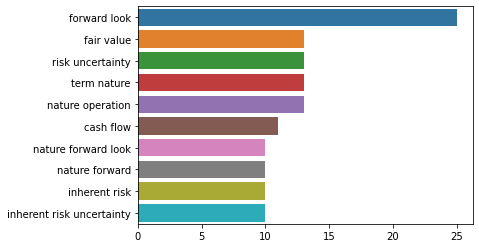

In [88]:
# filtering out the jargon
word2remove = [
               'consolidated', 'asset', 'assets',
               'libaility', 'liabilities', 'organization',
               'statement', 'ltd', 'cid',
               'keyera', 'inc', 'kel',
               'rimbey', 'lude', 'kei',
               'krl', 'year', 'end'
]

final_text = filtered_data.text.apply(lambda x: re.sub(' +', ' ', re.sub('|'.join(word2remove), '', x)).strip())

## this is just to see which words or phrases to take out and consider as jargon
maxdf, mindf = 0.99, 0.01 # default: 1.0 and 1 
count_vectorizer = CountVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
get_top_k(final_text, count_vectorizer)

In [70]:
# finalizing the text data 
filtered_data.text = final_text
filtered_data

,text,fileyear,rating_quarters
0,nature operation absolute software corporation...,2018,4
1,remain financial assess collectively base nature,2018,1
2,retirement obligation ur decommissioning recla...,2018,4
3,environmental services contract loss provision,2018,1
4,global short sea shipping segment company inte...,2018,1
...,...,...,...
236,total energy services total energy company gro...,2015,4
237,provision environmental rehabilitation defer o...,2015,4
238,carry value company amount receivable deposit ...,2015,4
239,total equity nature operation go concern note ...,2015,4


## Performing LDA

To extract topics from each document within the corpus

### Full Dataset

We want to try topic modelling on the full dataset first to see if there are distinct topics within these environmental disclosures

In [72]:
# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(filtered_data.text)
lda = LatentDirichletAllocation(n_components = 4, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.122833  0.030182       1        1  27.780322
1      0.079980  0.087715       2        1  26.514142
0      0.032520 -0.094189       3        1  25.707623
2      0.010333 -0.023708       4        1  19.997913, topic_info=                             Term      Freq  ...  logprob  loglift
303              nature operation  3.000000  ...  30.0000  30.0000
169  environmental rehabilitation  3.000000  ...  29.0000  29.0000
409              risk uncertainty  2.000000  ...  28.0000  28.0000
237                    go concern  1.000000  ...  27.0000  27.0000
305           nature operation go  1.000000  ...  26.0000  26.0000
..                            ...       ...  ...      ...      ...
60                      cash flow  1.168379  ...  -4.4665   0.7330
257           item capital nature  0.478785  ...  -5.3586   1.0035
255         investment tax credit  0.478785  ...  -5.3586   1.0035
216          financial instrument  0.545418  ...  -5.2283   0.5945
43                  balance sheet  0.507884  ...  -5.2996   0.7083

[176 rows x 6 columns], token_table=      Topic      Freq                       Term
term                                            
4         1  0.507007        accompany financial
4         4  0.507007        accompany financial
6         2  0.650482              accord nature
13        1  0.766436          accounting policy
23        1  0.679399  application environmental
...     ...       ...                        ...
449       2  0.632123   time initial recognition
451       4  0.616423               total energy
463       2  0.675478                value short
464       2  0.675478           value short term
468       1  0.849740                   year end

[142 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [74]:
# Showing the words for each topic
n_words_to_show = 8
fulldata_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
environmental permit, ongoing production, environmental requirement, forward look information, look information, operating segment, similarity nature, similarity nature product

Topic 1:
initial recognition, financial liability, environmental political, short term, short term nature, depend nature, term nature, fair value

Topic 2:
nature operation, go concern, nature operation go, operation go, operation go concern, total energy, energy ome, cash flow

Topic 3:
environmental rehabilitation, forward look, risk uncertainty, provision environmental, financial position, long term, year end, inherent risk uncertainty



**Evaluation**

Based on the topics seen above, I'd say that:

Topic 0 = Talking about the process of getting a permit. Attempting to meet environmental requirements

Topic 1 = The current value of environmental intervention being a liability

Topic 2 = Inconclusive (Cash and responsibility that's involved in the movement towards environmental concern)

Topic 3 = Conversations of fixing the environment and talking about the risks and uncertainties of attempting to do so

### Trying on rating 1 and 4

**Rating 1**

In [82]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 1, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 4, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.034674 -0.057520       1        1  29.207751
1     -0.034638  0.056523       2        1  27.751403
2      0.066425 -0.000622       3        1  22.688323
0      0.002888  0.001620       4        1  20.352522, topic_info=                         Term      Freq     Total Category  logprob  loglift
235              forward look  1.000000  1.000000  Default  30.0000  30.0000
65                  cash flow  1.000000  1.000000  Default  29.0000  29.0000
488          service business  1.000000  1.000000  Default  28.0000  28.0000
209                fair value  1.000000  1.000000  Default  27.0000  27.0000
466          risk uncertainty  0.000000  0.000000  Default  26.0000  26.0000
..                        ...       ...       ...      ...      ...      ...
268    interest joint venture  0.208297  0.492348   Topic4  -5.7711   0.7317
495        short sea shipping  0.208297  0.492348   Topic4  -5.7711   0.7317
280  joint venture novaalgoma  0.208297  0.492348   Topic4  -5.7711   0.7317
324          nature operation  0.310226  1.177349   Topic4  -5.3728   0.2582
540           total liability  0.223238  0.715139   Topic4  -5.7018   0.4277

[164 rows x 6 columns], token_table=      Topic      Freq                                    Term
term                                                         
6         3  1.274894                           accord nature
42        3  1.219633                      assumption subject
43        3  1.219633             assumption subject inherent
65        2  0.667411                               cash flow
141       2  1.066229                       december december
171       2  0.836302                         energy services
178       2  0.866172                    environmental permit
179       1  0.818830            environmental rehabilitation
180       1  0.971216               environmental requirement
209       3  0.940459                              fair value
221       2  0.792879                    financial instrument
235       3  0.621843                            forward look
239       3  1.219633                    forward look require
260       3  1.219633                           inherent risk
261       3  1.219633               inherent risk uncertainty
297       3  1.219633                            look require
298       3  1.219633                 look require assumption
312       2  0.876774                               month end
318       3  1.219633                          nature forward
319       3  1.219633                     nature forward look
324       3  0.849366                        nature operation
360       1  1.210547                      ongoing production
424       1  0.969215                 provision environmental
425       1  0.969215  provision environmental rehabilitation
458       3  1.219633                      require assumption
459       3  1.219633              require assumption subject
466       3  1.048160                        risk uncertainty
488       4  0.970332                        service business
520       3  1.219633                        subject inherent
521       3  1.219633                   subject inherent risk
528       1  1.210547                         sustain ongoing
529       1  1.210547              sustain ongoing production, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [83]:
# Showing the words for each topic
n_words_to_show = 8
rating_1_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
service business, go concern, nature operation go, operation go, operation go concern, short sea, nature operation, matter lack market

Topic 1:
cash flow, financial instrument, environmental permit, month end, energy services, december december, cost sale, end december december

Topic 2:
forward look, fair value, risk uncertainty, nature operation, forward look require, nature forward look, subject inherent, look require assumption

Topic 3:
environmental rehabilitation, provision environmental, provision environmental rehabilitation, environmental requirement, sustain ongoing, sustain ongoing production, ongoing production, financial liability



**Rating 4**

In [84]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.rating_quarters == 4, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 4, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.067228  0.009887       1        1  30.664653
0      0.046441  0.046850       2        1  27.346188
3      0.024972 -0.059972       3        1  26.145966
2     -0.004185  0.003235       4        1  15.843192, topic_info=                             Term      Freq  ...  logprob  loglift
260                  global dairy  0.000000  ...  30.0000  30.0000
210  environmental rehabilitation  1.000000  ...  29.0000  29.0000
368              nature operation  1.000000  ...  28.0000  28.0000
207          environmental permit  1.000000  ...  27.0000  27.0000
251                  forward look  1.000000  ...  26.0000  26.0000
..                            ...       ...  ...      ...      ...
220                      etf mind  0.205048  ...  -5.5707   0.9620
271               horizon robotic  0.205048  ...  -5.5707   0.9620
272    horizon robotic automation  0.205048  ...  -5.5707   0.9620
290                index etf robo  0.205048  ...  -5.5707   0.9620
397                 obligation ur  0.217855  ...  -5.5101   0.8574

[176 rows x 6 columns], token_table=      Topic      Freq                              Term
term                                                   
28        3  1.242581         application environmental
29        3  1.242581  application environmental permit
36        1  1.263119                  approximate fair
37        1  1.263119            approximate fair value
43        3  1.298158                assumption subject
...     ...       ...                               ...
550       1  1.257293                      time initial
551       1  1.257293          time initial recognition
558       3  0.967394                      total energy
587       1  1.263119                       value short
588       1  1.263119                  value short term

[64 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [85]:
# Showing the words for each topic
n_words_to_show = 8
rating_4_words = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
environmental rehabilitation, nature operation, provision environmental, rehabilitation provision, environmental rehabilitation provision, operation go, go concern, operation go concern

Topic 1:
purpose financial, initial recognition, depend nature, depend nature purpose, nature purpose, nature purpose financial, term nature, fair value

Topic 2:
global dairy, index etf, restoration rehabilitation, rehabilitation environmental, restoration rehabilitation environmental, financial position, constructive obligation ur, environmental cost

Topic 3:
forward look, environmental permit, total energy, financial result, risk uncertainty, inherent risk uncertainty, inherent risk, kei krl



**Comparison Summary**

In [86]:
summary_layout(rating_1_words, 
               rating_4_words)

topic 0
service business, go concern, nature operation go, operation go, operation go concern, short sea, nature operation, matter lack market
environmental rehabilitation, nature operation, provision environmental, rehabilitation provision, environmental rehabilitation provision, operation go, go concern, operation go concern


topic 1
cash flow, financial instrument, environmental permit, month end, energy services, december december, cost sale, end december december
purpose financial, initial recognition, depend nature, depend nature purpose, nature purpose, nature purpose financial, term nature, fair value


topic 2
forward look, fair value, risk uncertainty, nature operation, forward look require, nature forward look, subject inherent, look require assumption
global dairy, index etf, restoration rehabilitation, rehabilitation environmental, restoration rehabilitation environmental, financial position, constructive obligation ur, environmental cost


topic 3
environmental rehabilit

Highly rated companies tend to show more concern about nature and have conversational topics about adjusting their progress to work around nature instead of over nature (trying to leave nature as it is). 

They also seem to talk about the environmental cost when talking about rehabilitation of the environment instead of it being a financial liability. I guess what we can deduce from this is that higher rated companies are earning more because of their evident priorities when looking at environmental issues. 

### Trying on the different years

**2015**

In [40]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2015, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.006574  0.010218       1        1  22.804002
4      0.003277  0.002693       2        1  20.935020
0      0.006763 -0.011816       3        1  20.444748
2     -0.017627 -0.000270       4        1  20.156267
3      0.001012 -0.000825       5        1  15.659964, topic_info=                  Term      Freq     Total Category  logprob  loglift
1742  risk uncertainty  0.000000  0.000000  Default  30.0000  30.0000
1972       uncertainty  0.000000  0.000000  Default  29.0000  29.0000
859       forward look  0.000000  0.000000  Default  28.0000  28.0000
1170              look  0.000000  0.000000  Default  27.0000  27.0000
858            forward  0.000000  0.000000  Default  26.0000  26.0000
...                ...       ...       ...      ...      ...      ...
1294  nature operation  0.058180  0.305946   Topic5  -6.8996   0.1942
1250            mining  0.052800  0.233335   Topic5  -6.9966   0.3681
1393         operation  0.053602  0.340159   Topic5  -6.9815   0.0062
677             energy  0.053383  0.355853   Topic5  -6.9856  -0.0430
141         assumption  0.050897  0.306846   Topic5  -7.0333   0.0575

[271 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [41]:
# Showing the words for each topic
n_words_to_show = 8
year2015 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
december, end, corporation, nature, financial, month, month end, business

Topic 1:
energy, financial, company, service, nature, oil, contract, year

Topic 2:
risk uncertainty, uncertainty, look, forward, forward look, risk, subject inherent risk, look require assumption

Topic 3:
nexgen, nature, company, value, go, concern, go concern, infrastructure

Topic 4:
financial, note, lude, contingency, sustain, rease, production, law



**2016**

In [42]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2016, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004444  0.013696       1        1  27.550214
2      0.014996 -0.002775       2        1  24.054132
1     -0.010328 -0.009941       3        1  20.084983
3     -0.000580 -0.000162       4        1  14.959980
4      0.000356 -0.000818       5        1  13.350691, topic_info=                         Term      Freq     Total Category  logprob  loglift
1442           rehabilitation  0.000000  0.000000  Default  30.0000  30.0000
527                    energy  0.000000  0.000000  Default  29.0000  29.0000
1368  provision environmental  0.000000  0.000000  Default  28.0000  28.0000
1541                   rimbey  0.000000  0.000000  Default  27.0000  27.0000
418                  december  0.000000  0.000000  Default  26.0000  26.0000
...                       ...       ...       ...      ...      ...      ...
1368  provision environmental  0.051813  0.213969   Topic5  -6.7124   0.5954
968                 liability  0.051801  0.223760   Topic5  -6.7126   0.5504
527                    energy  0.048062  0.317577   Topic5  -6.7875   0.1254
1361                provision  0.046403  0.246804   Topic5  -6.8227   0.3424
1090                   nature  0.047202  0.488174   Topic5  -6.8056  -0.3226

[254 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4, 5])

In [43]:
# Showing the words for each topic
n_words_to_show = 8
year2016 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
nature, company, business, requirement, trevali, mining, customer, licence

Topic 1:
energy, lude, december, financial, month, end, expect, energy services

Topic 2:
nature, assumption, subject, require assumption subject, require assumption, subject inherent risk, subject inherent, forward look require

Topic 3:
reclamation, expenditure, reclamation expenditure charge, reclamation expenditure, charge provision, charge provision environmental, expenditure charge, expenditure charge provision

Topic 4:
environmental, rehabilitation, rimbey, legal, rehabilitation finance, rehabilitation finance liability, provision environmental rehabilitation, finance



**2017**

In [44]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2017, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.018667  0.001853       1        1  26.341986
4      0.007288  0.011986       2        1  21.090942
0      0.003909 -0.010144       3        1  20.112724
2      0.004705 -0.001492       4        1  17.082362
3      0.002765 -0.002203       5        1  15.371986, topic_info=           Term      Freq     Total Category  logprob  loglift
740         etf  0.000000  0.000000  Default  30.0000  30.0000
650         end  0.000000  0.000000  Default  29.0000  29.0000
2200       year  0.000000  0.000000  Default  28.0000  28.0000
1254      month  0.000000  0.000000  Default  27.0000  27.0000
1255  month end  0.000000  0.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
818   financial  0.073293  0.404370   Topic5  -6.7669   0.1648
337     company  0.068578  0.422095   Topic5  -6.8334   0.0554
1805     result  0.055765  0.227016   Topic5  -7.0402   0.4688
1771     report  0.054883  0.218287   Topic5  -7.0562   0.4920
1273     nature  0.063500  0.469528   Topic5  -6.9103  -0.1281

[258 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])

In [45]:
# Showing the words for each topic
n_words_to_show = 8
year2017 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
year, environmental, operation, nature, ore, corporation, iron, iron ore

Topic 1:
etf, energy, equity, index etf, robo, robotic, robotic automation, robotic automation index

Topic 2:
nature, company, financial, future, sale, financial liability, coffee, decaffeinate

Topic 3:
end, liability, december, month, month end, financial, short, corporation

Topic 4:
production, lude, audit, financial, environmental, environmental rehabilitation, environmental rehabilitation provision, rehabilitation provision



**2018**

In [46]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2018, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.017142 -0.001313       1        1  26.071933
2      0.008424 -0.009738       2        1  23.651851
0      0.005010  0.013378       3        1  22.535740
1      0.003624 -0.002061       4        1  18.300439
4      0.000085 -0.000266       5        1   9.440037, topic_info=                           Term      Freq     Total Category  logprob  loglift
723            financial result  0.000000  0.000000  Default  30.0000  30.0000
1588                     result  0.000000  0.000000  Default  29.0000  29.0000
471                    december  0.000000  0.000000  Default  28.0000  28.0000
1348                    prepare  0.000000  0.000000  Default  27.0000  27.0000
23                   accordance  0.000000  0.000000  Default  26.0000  26.0000
...                         ...       ...       ...      ...      ...      ...
1886                      value  0.030790  0.268973   Topic5  -6.9456   0.1928
561                      energy  0.032205  0.386430   Topic5  -6.9007  -0.1246
175                        base  0.028969  0.245127   Topic5  -7.0065   0.2247
43             acquire canadian  0.027926  0.159611   Topic5  -7.0432   0.6170
44    acquire canadian hydrovac  0.027926  0.159611   Topic5  -7.0432   0.6170

[268 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

In [47]:
# Showing the words for each topic
n_words_to_show = 8
year2018 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
provision, environmental, nature, time initial recognition, time initial, initial, initial recognition, recognition

Topic 1:
claim, environmental, corporation, prior, property, legal, unregistered, company

Topic 2:
energy, fund, nature, segment, ome, spark, novaalgoma, benefit

Topic 3:
december, financial, nature, cost, end, fair, fair value, value

Topic 4:
financial result, result, financial, base total, prepare, accordance, prepare accordance, prepare accordance ifrs



**Comparison Summary**

In [48]:
summary_layout(year2015,
               year2016,
               year2017,
               year2018)

topic 0
december, end, corporation, nature, financial, month, month end, business
nature, company, business, requirement, trevali, mining, customer, licence
year, environmental, operation, nature, ore, corporation, iron, iron ore
provision, environmental, nature, time initial recognition, time initial, initial, initial recognition, recognition


topic 1
energy, financial, company, service, nature, oil, contract, year
energy, lude, december, financial, month, end, expect, energy services
etf, energy, equity, index etf, robo, robotic, robotic automation, robotic automation index
claim, environmental, corporation, prior, property, legal, unregistered, company


topic 2
risk uncertainty, uncertainty, look, forward, forward look, risk, subject inherent risk, look require assumption
nature, assumption, subject, require assumption subject, require assumption, subject inherent risk, subject inherent, forward look require
nature, company, financial, future, sale, financial liability, coffee, de

### Trying on the rating and the years

In [49]:
# Creating the rating's dataset
scoped_data = filtered_data.loc[filtered_data.fileyear == 2015, :]
scoped_data = scoped_data.loc[scoped_data.rating_quarters == 4, :]

# Training the LDA model
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 3),
                                   max_df = maxdf,
                                   min_df = mindf,
                                   max_features = None)
tfidf_fit = tfidf_vectorizer.fit_transform(scoped_data.text)
lda = LatentDirichletAllocation(n_components = 5, 
                                random_state = 69)
lda.fit(tfidf_fit)

# LDA visualisation
pyLDAvis.sklearn.prepare(lda, tfidf_fit, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.012316 -0.004416       1        1  31.849544
2     -0.013549 -0.004450       2        1  22.398359
3      0.001443 -0.002568       3        1  22.160350
1     -0.000170  0.013398       4        1  15.740607
4     -0.000040 -0.001965       5        1   7.851140, topic_info=                            Term      Freq     Total Category  logprob  loglift
68   assumption subject inherent  0.000000  0.000000  Default  30.0000  30.0000
490      look require assumption  0.000000  0.000000  Default  29.0000  29.0000
707                      require  0.000000  0.000000  Default  28.0000  28.0000
708           require assumption  0.000000  0.000000  Default  27.0000  27.0000
709   require assumption subject  0.000000  0.000000  Default  26.0000  26.0000
..                           ...       ...       ...      ...      ...      ...
491                         lude  0.013342  0.231666   Topic5  -6.8443  -0.3099
420                      initial  0.013342  0.234891   Topic5  -6.8443  -0.3237
537             nature operation  0.013341  0.240502   Topic5  -6.8443  -0.3473
582                    operation  0.013341  0.240502   Topic5  -6.8443  -0.3473
284                       equity  0.013341  0.232090   Topic5  -6.8443  -0.3118

[260 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [50]:
# Showing the words for each topic
n_words_to_show = 8
year2015rating4 = display_topics(lda, tfidf_vectorizer.get_feature_names(), n_words_to_show)

Topic 0:
company, financial, energy, nature, rease, total energy, total, performance

Topic 1:
note, nature operation go, go concern, concern, go, concern note, operation go concern, operation go

Topic 2:
application, nature, company, fund, ifrs, capital, settlement, equity

Topic 3:
nexgen, company, financial, significant, ome tax, provision environmental, rehabilitation defer, defer

Topic 4:
subject, inherent, assumption subject inherent, look require, inherent risk uncertainty, inherent risk, forward look require, look require assumption

